# Load Data

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("sam-paech/mmlu-pro-nomath-sml")

In [3]:
dataset

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src'],
        num_rows: 2639
    })
    validation: Dataset({
        features: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src'],
        num_rows: 70
    })
})

In [4]:
# dataset["test"]
df = dataset["test"].to_pandas()

In [11]:
df

,question_id,question,options,answer,answer_index,cot_content,category,src
0,70,"Typical advertising regulatory bodies suggest,...","[Safe practices, Fear, Jealousy, Trivial, Unsa...",I,8,,business,ori_mmlu-business_ethics
1,71,Managers are entrusted to run the company in t...,"[Shareholders, Diligence, Self-interest, Share...",F,5,,business,ori_mmlu-business_ethics
2,72,There are two main issues associated with ____...,"[Down, Autonomy, Remuneration, Benefit, Down, ...",J,9,,business,ori_mmlu-business_ethics
3,73,_______ locate morality beyond the sphere of r...,"[Ethical egoism, Ethics of duty, Postmodern et...",C,2,,business,ori_mmlu-business_ethics
4,74,Some of key differences between Islamic finan...,"[Interest, Certain, Assured, Both tangible and...",G,6,,business,ori_mmlu-business_ethics
...,...,...,...,...,...,...,...,...
2634,12182,Let X be the random variable denoting the resu...,"[f(0) = (0) and f(1) = (1), f(0) = (1/2) and f...",B,1,,engineering,stemez-ElectronicCommunications
2635,12192,The resistance in the circuit of the moving co...,"[Low., Very low., High., Almost zero.]",C,2,,engineering,ori_mmlu-electrical_engineering
2636,12193,A Binary number system has how many digits.,"[0, 1, 2, 10]",C,2,,engineering,ori_mmlu-electrical_engineering
2637,12194,Speed of data transmission in 4-G network of t...,"[10 gbps - 100 gbps., 50 mbps - 500 mbps., 2 m...",D,3,,engineering,ori_mmlu-electrical_engineering


# Experiment!

In [77]:
import jsonlines
import os

from llm_council.processors.council_service import (
    get_default_council_service,
    CouncilService,
)

OUTDIR = "data/mmlu_pro.n100.mini.run2"

CHOICE_MAP = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K", 
    11: "L", 
    12: "M", 
}

def get_options_string(options):
    str = ""
    option_strings = []
    for i, option in enumerate(options):
        option_strings.append(f"{CHOICE_MAP[i]}: {option}")
    return ", ".join(option_strings)
    

def get_answer_string(options, answer_index):
    return CHOICE_MAP[answer_index] + ": " + options[answer_index]
    

STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST = '''The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Think step by step and then decide on your final answer. Your final answer should be a letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
'''

STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND = '''The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Provide your final answer, and then provide your reasoning for it. Your final answer should be a letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
'''

STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_NO_COT = '''The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Your final answer should be a letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
'''

PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST = """The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Think step by step and then finish your answer with "My assessment is (X)." where X is the letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
"""

PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND = """The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Begin your answer with "My assessment is (X)." where X is the letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.

Then, provide your reasoning for your answer.
"""

PROMPT_JUDGE_GROUND_TRUTH_NO_COT = """The following multiple-choice question was asked to a {role}.

Question: {question}

Options: {options}

The {role}'s answer was:
{answer}

Please assess whether the {role} is correct or incorrect, or if you do not know. 

Begin your answer with "My assessment is (X)." where X is the letter choice that corresponds to:
A: the {role} is correct
B: the {role} is wrong
C: I am not sure or I am unable to assess the correctness confidently.
"""


PROMPT_ANSWER_COT_FIRST = '''The following are multiple-choice questions (with answers). Think step by step and then finish your answer with "The answer is (X)" where X is the correct letter choice.

Question: {question}

Options: {options}
'''


PROMPT_ANSWER_COT_SECOND = '''The following are multiple-choice questions (with answers). Respond with: "The answer is (X)" where X is the correct letter choice. Then, provide your reasoning for it.

Question: {question}

Options: {options}
'''

STRUCTURED_OUTPUT_ANSWER_COT_FIRST = '''The following are multiple-choice questions (with answers). Think step by step, and then respond with a JSON payload with your reasoning and your final answer corresponding to the correct letter choice.

Question: {question}

Options: {options}
'''


STRUCTURED_OUTPUT_ANSWER_COT_SECOND = '''The following are multiple-choice questions (with answers). Respond with a JSON payload with your final answer corresponding to the correct letter choice and then your reasoning for it.

Question: {question}

Options: {options}
'''

STRUCTURED_OUTPUT_ANSWER_NO_COT = '''The following are multiple-choice questions (with answers). Respond with a JSON payload with your final answer corresponding to the correct letter choice.

Question: {question}

Options: {options}
'''

PROMPT_ANSWER_NO_COT = '''The following are multiple-choice questions (with answers). Begin your response with "The answer is (X)" where X is the correct letter choice.

Question: {question}

Options: {options}
'''

PROMPT_MAP = {
    "so_jgt_cot1": STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    "so_jgt_cot2": STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    "so_jgt_cot0": STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_NO_COT,
    "pr_jgt_cot1": PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    "pr_jgt_cot2": PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    "pr_jgt_cot0": PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    "pr_ans_cot1": PROMPT_ANSWER_COT_FIRST,
    "pr_ans_cot2": PROMPT_ANSWER_COT_SECOND,
    "pr_ans_cot0": PROMPT_ANSWER_NO_COT,
    "so_ans_cot1": STRUCTURED_OUTPUT_ANSWER_COT_FIRST,
    "so_ans_cot2": STRUCTURED_OUTPUT_ANSWER_COT_SECOND,
    "so_ans_cot0": STRUCTURED_OUTPUT_ANSWER_NO_COT,
}


def generate_requests(
    prompt_name,
    should_judge_ground_truth,
    temperature,
    schema_name=None,
    role=None,
):
    base_prompt = PROMPT_MAP[prompt_name]
    outdir = os.path.join(
        OUTDIR, 
        ".".join([
            prompt_name,
            # "judge_ground_truth" if should_judge_ground_truth else "answer",
            schema_name if schema_name else "no_schema",
            f"temp{temperature}",
            role if role else "no_role",
    ]))
    
    council_service = CouncilService(
        llm_council_members=[
            "openai://gpt-4o-mini-2024-07-18", 
            # "openai://gpt-4o-2024-08-06",
        ],
        outdir=outdir,
    )
    
    # for i, row in df.iterrows():
    # for i, row in df.head(10).iterrows():
    for i, row in df.head(100).iterrows():
        realized_prompt = base_prompt.format(
            role=role,
            question=row.question,
            options=get_options_string(row.options),
            answer=get_answer_string(row.options, row.answer_index)
        )
        metadata = {
            "completion_request": {
                "question_id": row["question_id"],
                "temperature": temperature,
                "schema_name": schema_name,
                "should_judge_ground_truth": should_judge_ground_truth,
                "role": role,
            }
        }
        council_service.write_council_request(
            realized_prompt, metadata, temperature, schema_name=schema_name,
        )


# STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST
generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=0,
    role="student",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=1,
    role="student",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=0,
    role="expert",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="so_jgt_cot1",
    should_judge_ground_truth=True,
    schema_name="reasoning_then_answer",
    temperature=1,
    role="expert",
)

# STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND
generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=0,
    role="student",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=1,
    role="student",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=0,
    role="expert",
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="so_jgt_cot2",
    should_judge_ground_truth=True,
    schema_name="answer_then_reasoning",
    temperature=1,
    role="expert",
)

# STRUCTURED_OUTPUT_JUDGE_GROUND_TRUTH_NO_COT
generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=0,
    role="student",
)

generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=1,
    role="student",
)

generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=0,
    role="expert",
)

generate_requests(
    prompt_name="so_jgt_cot0",
    should_judge_ground_truth=True,
    schema_name="answer_only",
    temperature=1,
    role="expert",
)

# PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST
generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="expert",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_FIRST,
    prompt_name="pr_jgt_cot1",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="expert",
)

# PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND
generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="expert",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_COT_SECOND,
    prompt_name="pr_jgt_cot2",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="expert",
)

# PROMPT_JUDGE_GROUND_TRUTH_NO_COT
generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="student",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=0,
    role="expert",
)

generate_requests(
    # base_prompt=PROMPT_JUDGE_GROUND_TRUTH_NO_COT,
    prompt_name="pr_jgt_cot0",
    should_judge_ground_truth=True,
    # schema_name="no_schema",
    temperature=1,
    role="expert",
)

# PROMPT_ANSWER_COT_FIRST
generate_requests(
    # base_prompt=PROMPT_ANSWER_COT_FIRST,
    prompt_name="pr_ans_cot1",
    should_judge_ground_truth=False,
    # schema_name="no_schema",
    temperature=0,
)

generate_requests(
    # base_prompt=PROMPT_ANSWER_COT_FIRST,
    prompt_name="pr_ans_cot1",
    should_judge_ground_truth=False,
    # schema_name="no_schema",
    temperature=1,
)

# PROMPT_ANSWER_COT_SECOND
generate_requests(
    # base_prompt=PROMPT_ANSWER_COT_SECOND,
    prompt_name="pr_ans_cot2",
    should_judge_ground_truth=False,
    # schema_name="no_schema",
    temperature=0,
)

generate_requests(
    # base_prompt=PROMPT_ANSWER_COT_SECOND,
    prompt_name="pr_ans_cot2",
    should_judge_ground_truth=False,
    # schema_name="no_schema",
    temperature=1,
)

# PROMPT_ANSWER_NO_COT
generate_requests(
    # base_prompt=PROMPT_ANSWER_NO_COT,
    prompt_name="pr_ans_cot0",
    should_judge_ground_truth=False,
    temperature=0,
)

generate_requests(
    # base_prompt=PROMPT_ANSWER_NO_COT,
    prompt_name="pr_ans_cot0",
    should_judge_ground_truth=False,
    temperature=1,
)

# STRUCTURED_OUTPUT_ANSWER_COT_FIRST
generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_COT_FIRST,
    prompt_name="so_ans_cot1",
    should_judge_ground_truth=False,
    schema_name="reasoning_then_answer",
    temperature=0,
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_COT_FIRST,
    prompt_name="so_ans_cot1",
    should_judge_ground_truth=False,
    schema_name="reasoning_then_answer",
    temperature=1,
)

# STRUCTURED_OUTPUT_ANSWER_COT_SECOND
generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_COT_SECOND,
    prompt_name="so_ans_cot2",
    should_judge_ground_truth=False,
    schema_name="answer_then_reasoning",
    temperature=0,
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_COT_SECOND,
    prompt_name="so_ans_cot2",
    should_judge_ground_truth=False,
    schema_name="answer_then_reasoning",
    temperature=1,
)

# STRUCTURED_OUTPUT_ANSWER_NO_COT
generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_NO_COT,
    prompt_name="so_ans_cot0",
    should_judge_ground_truth=False,
    schema_name="answer_only",
    temperature=0,
)

generate_requests(
    # base_prompt=STRUCTURED_OUTPUT_ANSWER_NO_COT,
    prompt_name="so_ans_cot0",
    should_judge_ground_truth=False,
    schema_name="answer_only",
    temperature=1,
)

In [ ]:
# Execute requests.

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n10.mini.run0

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n10.mini.run1

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n10.mini.run2

170.18 seconds for 10 each.


python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n100.mini.run0

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n100.mini.run1

python llm_council/invocation/execute_council.py \
    --requests_dir data/mmlu_pro.n100.mini.run2

346.10 seconds for 100 each.

# Analyze results

In [111]:
from datasets import load_dataset
from llm_council.utils import jsonl_io
import jsonlines
import os
import json
import pandas as pd
import numpy as np


from llm_council.processors.council_service import (
    get_default_council_service,
    CouncilService,
)

CHOICE_MAP = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K",
    11: "L",
    12: "M",
}


def get_metadata_for_response_file(response_filename):
    # This varies depending on the responses base directory.
    components = response_filename.split("/")[2]
    metadata_pieces = components.split(".")

    return {
        "prompt_template": metadata_pieces[0],
        "schema_name": metadata_pieces[1],
        "temperature": metadata_pieces[2],
        "role": metadata_pieces[3],
        "llm": response_filename.split("/")[-2],
    }


council_service = CouncilService(
    llm_council_members=[
        "openai://gpt-4o-mini-2024-07-18",
    ]
)


def parse_my_assessment_substring(response_string):
    response_string = response_string.lower()
    if "my assessment is" in response_string:
        response_string = (
            response_string.replace("*", "").replace("(", "").replace(")", "")
        )
        assessment = response_string.split("my assessment is ")[-1][0]
        return assessment.upper()
    if "the answer is " in response_string:
        response_string = (
            response_string.replace("*", "").replace("(", "").replace(")", "")
        )
        assessment = response_string.split("the answer is ")[-1][0]
        return assessment.upper()
    return "ERROR"


def get_metrics(responses_file):
    num_items = 0
    num_correct_items = 0
    num_unparsable_items = 0
    num_uncertain_items_for_judging_ground_truth = 0
    response_lengths = []

    metadata_for_response_file = get_metadata_for_response_file(responses_file)

    with jsonlines.open(responses_file) as reader:
        for response_data in reader:
            num_items += 1

            llm_responder = response_data[-1]["llm"]
            response_string = council_service.get_llm_response_string(response_data)
            response_lengths.append(len(response_string))

            question_id = response_data[-1]["completion_request"]["question_id"]

            df_row = df[df["question_id"] == question_id]

            if metadata_for_response_file["schema_name"] != "no_schema":
                try:
                    json_payload = json.loads(response_string)
                except:
                    breakpoint()
                try:
                    parsed_assessment = json_payload["answer"]
                except:
                    parsed_assessment = "ERROR"
            else:
                parsed_assessment = parse_my_assessment_substring(response_string)

            if parsed_assessment == "ERROR":
                num_unparsable_items += 1
                continue

            if "ans" in metadata_for_response_file["prompt_template"]:
                ground_truth = df_row["answer"].item()
                if parsed_assessment == ground_truth:
                    num_correct_items += 1
            else:
                # Judge ground truth. The answer should just be A.
                if parsed_assessment == "A":
                    num_correct_items += 1
                if parsed_assessment == "C":
                    num_uncertain_items_for_judging_ground_truth += 1

    return {
        "accuracy": num_correct_items / num_items,
        "pct_unparsable_items": num_unparsable_items / num_items,
        "pct_uncertain_items_for_jgt": num_uncertain_items_for_judging_ground_truth
        / num_items,
        "response_length_mean": np.mean(response_lengths),
        "response_length_stdev": np.std(response_lengths)
    }


def get_stats_for_responses_files(outdir):
    responses_files = jsonl_io.find_response_files(outdir)
    stats = []
    for responses_file in responses_files:
        metadata = get_metadata_for_response_file(responses_file)
        
        metrics = get_metrics(responses_file)

        metadata.update(**metrics)
        stats.append(metadata)

    return pd.DataFrame(stats)


dataset = load_dataset("sam-paech/mmlu-pro-nomath-sml")
df = dataset["test"].to_pandas()

In [112]:
df0 = get_stats_for_responses_files("data/mmlu_pro.n100.mini.run0")
df1 = get_stats_for_responses_files("data/mmlu_pro.n100.mini.run1")
df2 = get_stats_for_responses_files("data/mmlu_pro.n100.mini.run2")

In [117]:
merged_df = df0.merge(df1, how="left", on=["prompt_template", "schema_name", "temperature", "role", "llm"], suffixes=["_0", "_1"])
merged_df = merged_df.merge(df2, how="left", on=["prompt_template", "schema_name", "temperature", "role", "llm"])
merged_df = merged_df.rename(columns={
    "accuracy": "accuracy_2",
    "pct_unparsable_items": "pct_unparsable_items_2",
    "pct_uncertain_items_for_jgt": "pct_uncertain_items_for_jgt_2",
    "response_length_mean": "response_length_mean_2",
    "response_length_stdev": "response_length_stdev_2",
})

merged_df["accuracy_mean"] = np.mean(merged_df[["accuracy_1", "accuracy_0", "accuracy_2"]], axis=1)
merged_df["accuracy_stdev"] = np.std(merged_df[["accuracy_1", "accuracy_0", "accuracy_2"]], axis=1)


merged_df.to_clipboard()

In [164]:
# df[df["question_id"] == 71]

In [66]:
# parse_my_assessment_substring("The answer is J. Quantitative.")

'J'

In [70]:
# get_metrics("data/mmlu_pro.n10.mini.run0/pr_ans_cot0.no_schema.temp1.no_role/openai/gpt-4o-mini-2024-07-18/responses.jsonl")

{'accuracy': 0.2,
 'pct_unparsable_items': 0.0,
 'pct_uncertain_items_for_judging_ground_truth': 0.0}

In [159]:
merged_df

,prompt_template,schema_name,temperature,role,llm,accuracy_0,pct_unparsable_items_0,pct_uncertain_items_for_jgt_0,response_length_mean_0,response_length_stdev_0,...,accuracy_2,pct_unparsable_items_2,pct_uncertain_items_for_jgt_2,response_length_mean_2,response_length_stdev_2,accuracy_mean,accuracy_stdev,cot_type,output_type,prompt_type
0,pr_ans_cot1,no_schema,temp1,no_role,gpt-4o-mini-2024-07-18,0.65,0.0,0.00,1482.51,522.560666,...,0.71,0.00,0.00,1451.70,482.536848,0.673333,0.026247,cot1,Unstructured,ANS
1,so_ans_cot0,answer_only,temp1,no_role,gpt-4o-mini-2024-07-18,0.54,0.0,0.00,14.00,0.000000,...,0.56,0.00,0.00,14.00,0.000000,0.556667,0.012472,cot0,Structured,ANS
2,so_jgt_cot1,reasoning_then_answer,temp1,student,gpt-4o-mini-2024-07-18,0.73,0.0,0.00,1120.61,556.635085,...,0.76,0.00,0.00,1131.56,588.709543,0.740000,0.014142,cot1,Structured,JGT
3,pr_jgt_cot2,no_schema,temp0,expert,gpt-4o-mini-2024-07-18,0.59,0.0,0.00,629.17,222.560197,...,0.56,0.00,0.00,634.80,219.276082,0.576667,0.012472,cot2,Unstructured,JGT
4,so_ans_cot1,reasoning_then_answer,temp0,no_role,gpt-4o-mini-2024-07-18,0.72,0.0,0.00,974.58,559.049482,...,0.69,0.00,0.00,953.97,544.018795,0.710000,0.014142,cot1,Structured,ANS
5,pr_ans_cot1,no_schema,temp0,no_role,gpt-4o-mini-2024-07-18,0.67,0.0,0.00,1491.62,460.781679,...,0.67,0.00,0.00,1486.36,471.606669,0.676667,0.009428,cot1,Unstructured,ANS
6,so_ans_cot0,answer_only,temp0,no_role,gpt-4o-mini-2024-07-18,0.60,0.0,0.00,14.00,0.000000,...,0.59,0.00,0.00,14.00,0.000000,0.586667,0.012472,cot0,Structured,ANS
7,so_jgt_cot1,reasoning_then_answer,temp0,student,gpt-4o-mini-2024-07-18,0.79,0.0,0.00,1094.93,533.476827,...,0.80,0.00,0.00,1099.52,549.621624,0.810000,0.021602,cot1,Structured,JGT
8,so_jgt_cot1,reasoning_then_answer,temp1,expert,gpt-4o-mini-2024-07-18,0.82,0.0,0.01,1213.60,579.841271,...,0.81,0.01,0.00,1156.65,519.147270,0.816667,0.004714,cot1,Structured,JGT
9,pr_jgt_cot1,no_schema,temp0,expert,gpt-4o-mini-2024-07-18,0.86,0.0,0.00,1637.79,518.169727,...,0.85,0.00,0.00,1620.03,518.554326,0.853333,0.004714,cot1,Unstructured,JGT


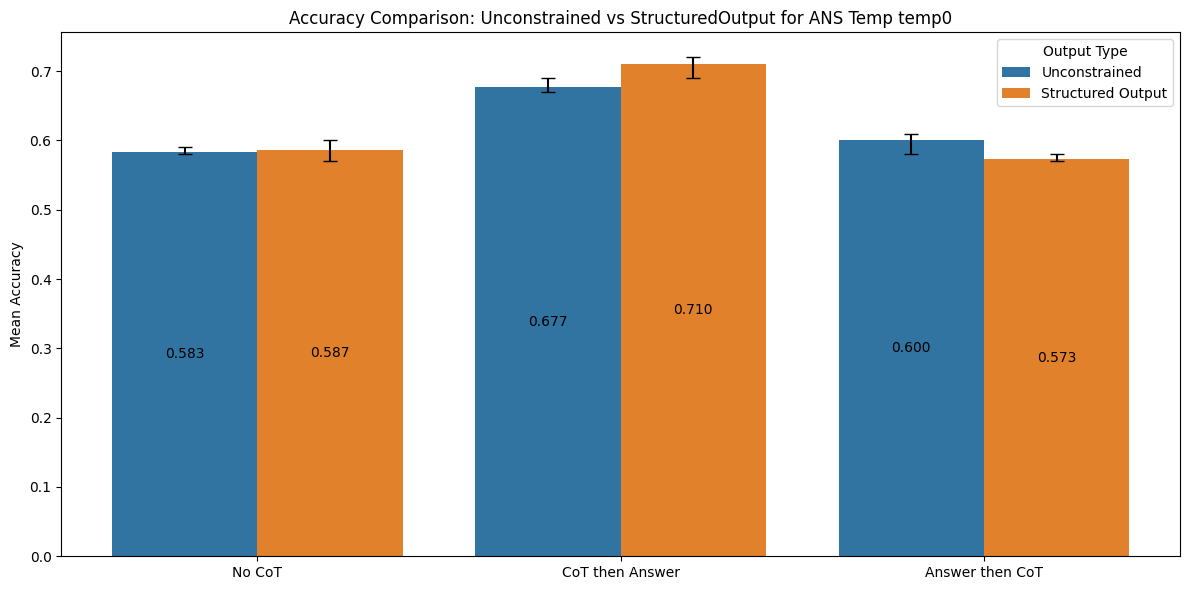

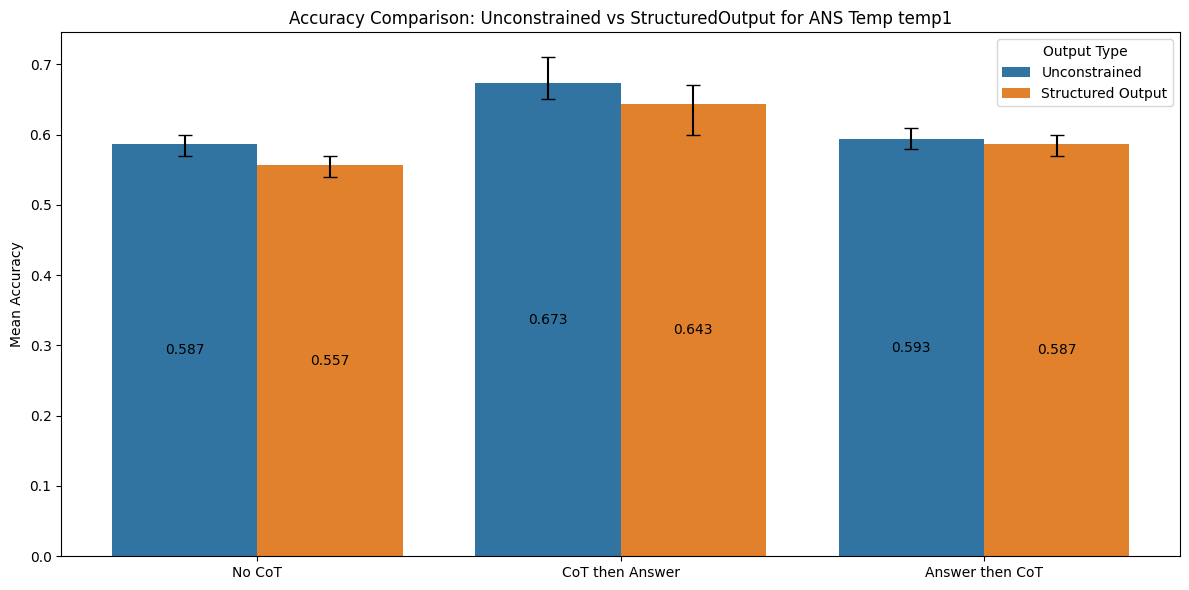

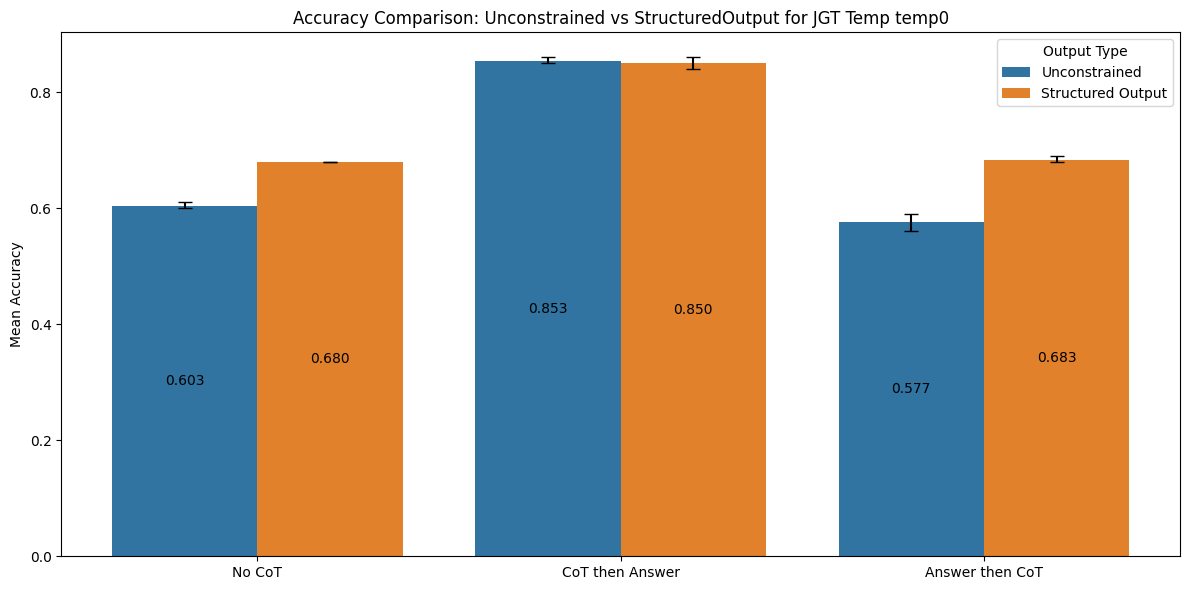

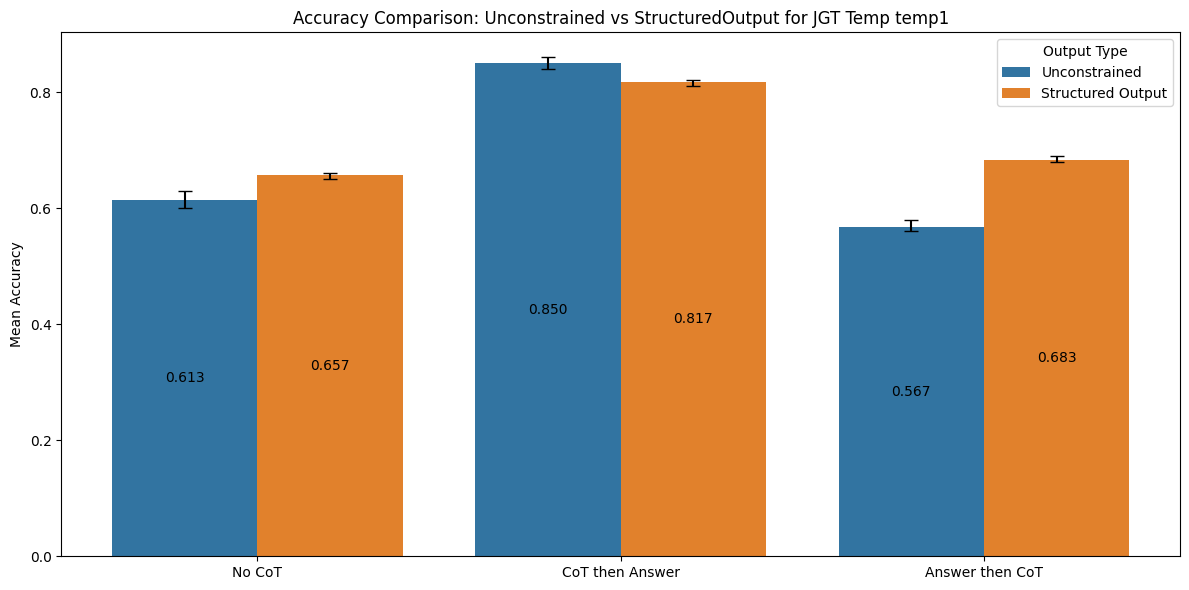

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to classify schema names as "Unconstrained" or "StructuredOutput"
def classify_schema(schema_name):
    if schema_name == 'NoSchema':
        return 'Unconstrained'
    else:
        return 'Structured Output'

# Mapping for renaming CoT types
cot_labels = {
    'cot0': 'No CoT',
    'cot1': 'CoT then Answer',
    'cot2': 'Answer then CoT'
}

# Function to plot the grouped bar graph with error bars
def plot_grouped_bars(filtered_df, ans_jgt, temp):
    plt.figure(figsize=(12, 6))
    
    # Ensure cot_type is ordered as 'cot0', 'cot1', 'cot2'
    cot_order = ['cot0', 'cot1', 'cot2']
    
    # Map schema_name to either "Unconstrained" or "StructuredOutput"
    filtered_df['schema_group'] = filtered_df['schema_name'].apply(classify_schema)
    
    # Calculate min and max accuracy values
    filtered_df['accuracy_min'] = filtered_df[['accuracy_0', 'accuracy_1', 'accuracy_2']].min(axis=1)
    filtered_df['accuracy_max'] = filtered_df[['accuracy_0', 'accuracy_1', 'accuracy_2']].max(axis=1)
    
    # Calculate the error bars as difference between accuracy mean and min/max
    filtered_df['yerr_lower'] = filtered_df['accuracy_mean'] - filtered_df['accuracy_min']
    filtered_df['yerr_upper'] = filtered_df['accuracy_max'] - filtered_df['accuracy_mean']

    # Create the bar plot comparing "Unconstrained" vs "StructuredOutput"
    ax = sns.barplot(
        x='cot_type', y='accuracy_mean', hue='schema_group', data=filtered_df,
        hue_order=['Unconstrained', 'Structured Output'],
        order=cot_order,
        dodge=True,
        errorbar=None
    )
    
    # Add text annotations for each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='center')
    
    # Add custom error bars
    for i, cot in enumerate(cot_order):
        for j, schema in enumerate(['Unconstrained', 'Structured Output']):
            bar_data = filtered_df[(filtered_df['cot_type'] == cot) & (filtered_df['schema_group'] == schema)]
            if not bar_data.empty:
                bar = ax.containers[j][i]
                ax.errorbar(
                    bar.get_x() + bar.get_width() / 2,
                    bar_data['accuracy_mean'].values[0],
                    yerr=[[bar_data['yerr_lower'].values[0]], [bar_data['yerr_upper'].values[0]]],
                    fmt='none',
                    color='black',
                    capsize=5
                )

    # Set custom x-tick positions and labels
    num_categories = len(cot_order)
    ax.set_xticks(range(num_categories))
    ax.set_xticklabels([cot_labels[label] for label in cot_order])

    # Set the title and labels
    plt.title(f'Accuracy Comparison: Unconstrained vs StructuredOutput for {ans_jgt.upper()} Temp {temp}')
    plt.ylabel('Mean Accuracy')
    plt.xlabel('')
    plt.legend(title='Output Type')
    plt.tight_layout()
    plt.show()

# Loop over ans/jgt and temperature, and plot cot0, cot1, cot2 in one figure
for ans_jgt in ['ans', 'jgt']:
    for temp in ['temp0', 'temp1']:
        # Filter for ans_jgt and temperature
        filtered_df = merged_df[
            (merged_df['prompt_template'].str.contains(f"{ans_jgt}")) &
            (merged_df['temperature'] == temp) &
            (merged_df['role'].isin({"no_role", "expert"}))
        ].copy()
        
        # Replace schema_name with title case labels
        filtered_df['schema_name'] = filtered_df['schema_name'].map(schema_mapping)

        # Add CoT type as a separate column (cot0, cot1, cot2)
        filtered_df['cot_type'] = filtered_df['prompt_template'].apply(lambda x: x.split('_')[-1])

        # Plot grouped bars for each combination of ans/jgt and temperature
        plot_grouped_bars(filtered_df, ans_jgt, temp)

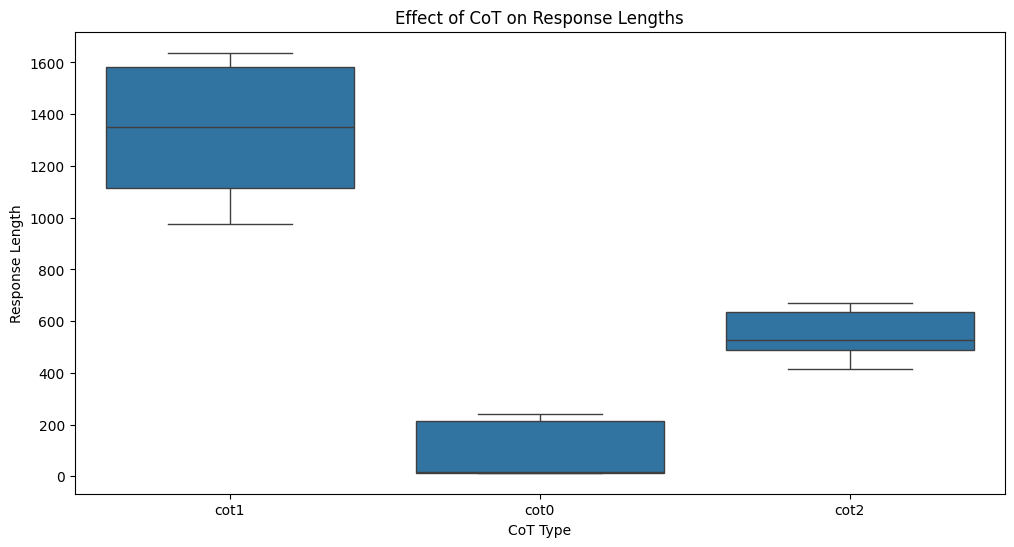

Average response lengths by CoT type:
cot_type
cot0      86.637500
cot1    1338.561667
cot2     549.438333
Name: response_length_mean_0, dtype: float64


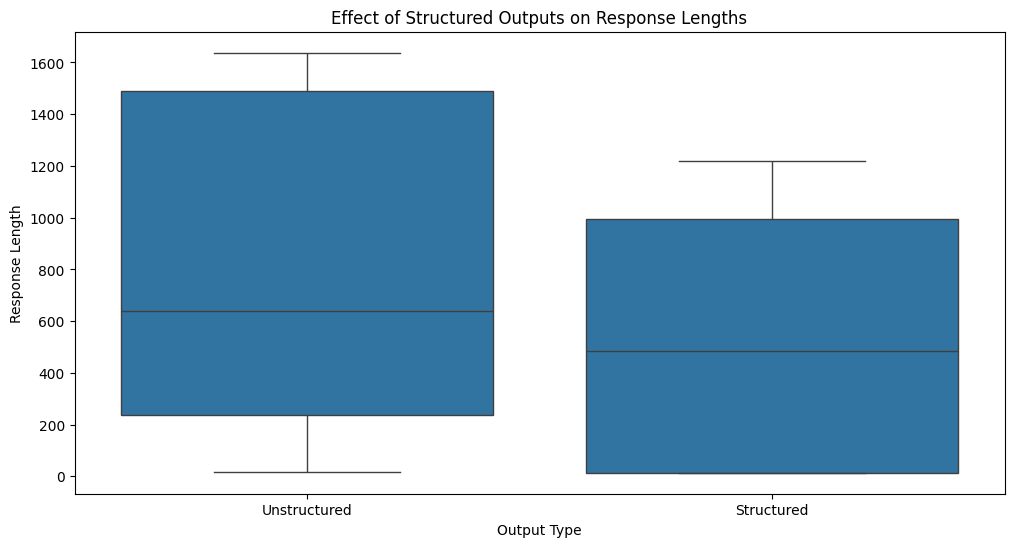


Average response lengths by output type:
output_type
Structured      532.357778
Unstructured    784.067222
Name: response_length_mean_0, dtype: float64


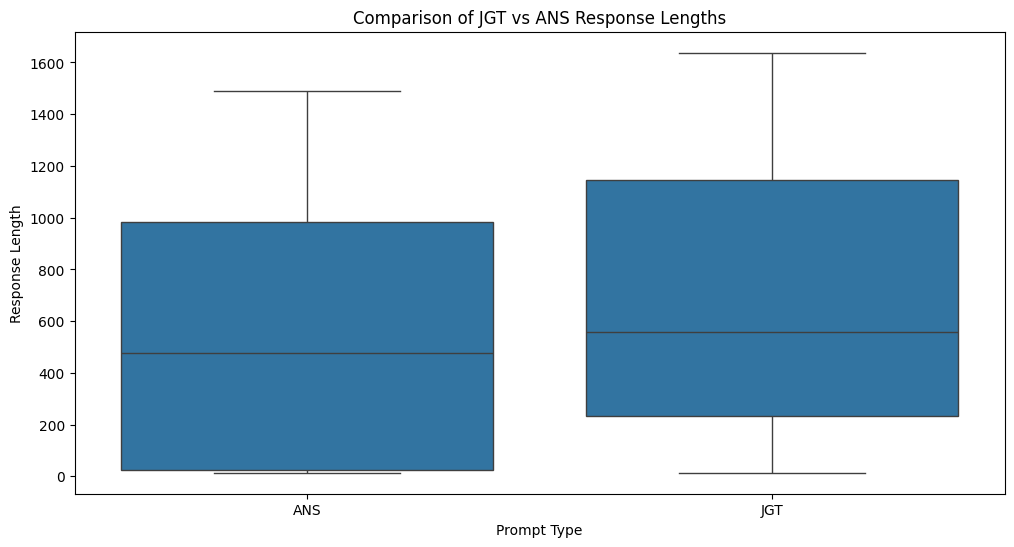


Average response lengths by prompt type:
prompt_type
ANS    586.898333
JGT    693.869583
Name: response_length_mean_0, dtype: float64


In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df is your existing dataframe

def analyze_response_lengths(df):
    # 1. Effect of CoT on response lengths
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='cot_type', y='response_length_mean_0', data=df)
    plt.title('Effect of CoT on Response Lengths')
    plt.xlabel('CoT Type')
    plt.ylabel('Response Length')
    plt.show()

    # Calculate and print average lengths for each CoT type
    cot_avg_lengths = df.groupby('cot_type')['response_length_mean_0'].mean()
    print("Average response lengths by CoT type:")
    print(cot_avg_lengths)

    # 2. Effect of structured outputs on response lengths
    plt.figure(figsize=(12, 6))
    df['output_type'] = df['schema_name'].apply(lambda x: 'Structured' if x != 'no_schema' else 'Unstructured')
    sns.boxplot(x='output_type', y='response_length_mean_0', data=df)
    plt.title('Effect of Structured Outputs on Response Lengths')
    plt.xlabel('Output Type')
    plt.ylabel('Response Length')
    plt.show()

    # Calculate and print average lengths for structured vs unstructured
    output_avg_lengths = df.groupby('output_type')['response_length_mean_0'].mean()
    print("\nAverage response lengths by output type:")
    print(output_avg_lengths)

    # 3. Comparison of JGT vs ANS response lengths
    plt.figure(figsize=(12, 6))
    df['prompt_type'] = df['prompt_template'].apply(lambda x: 'JGT' if 'jgt' in x else 'ANS')
    sns.boxplot(x='prompt_type', y='response_length_mean_0', data=df)
    plt.title('Comparison of JGT vs ANS Response Lengths')
    plt.xlabel('Prompt Type')
    plt.ylabel('Response Length')
    plt.show()

    # Calculate and print average lengths for JGT vs ANS
    prompt_avg_lengths = df.groupby('prompt_type')['response_length_mean_0'].mean()
    print("\nAverage response lengths by prompt type:")
    print(prompt_avg_lengths)

# Prepare the data
merged_df['cot_type'] = merged_df['prompt_template'].apply(lambda x: x.split('_')[-1])

# Run the analysis
analyze_response_lengths(merged_df)

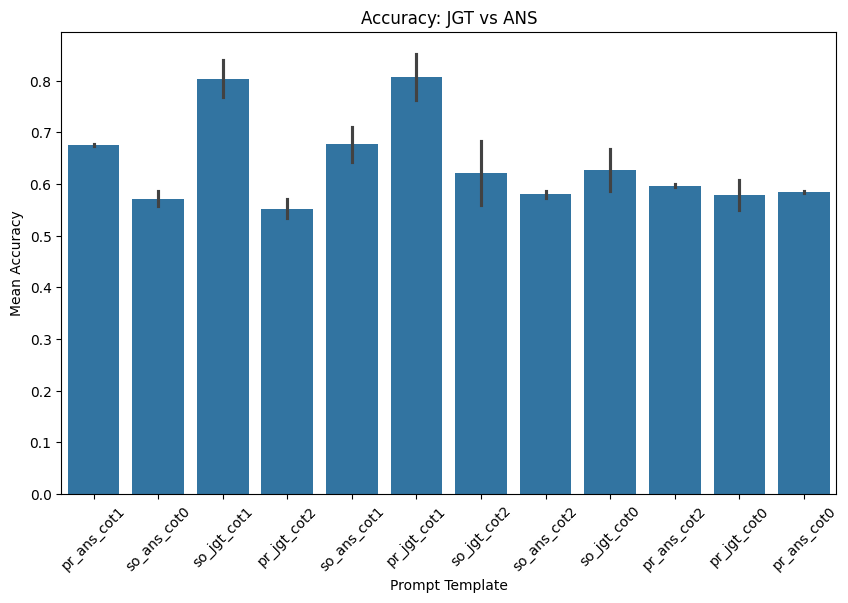

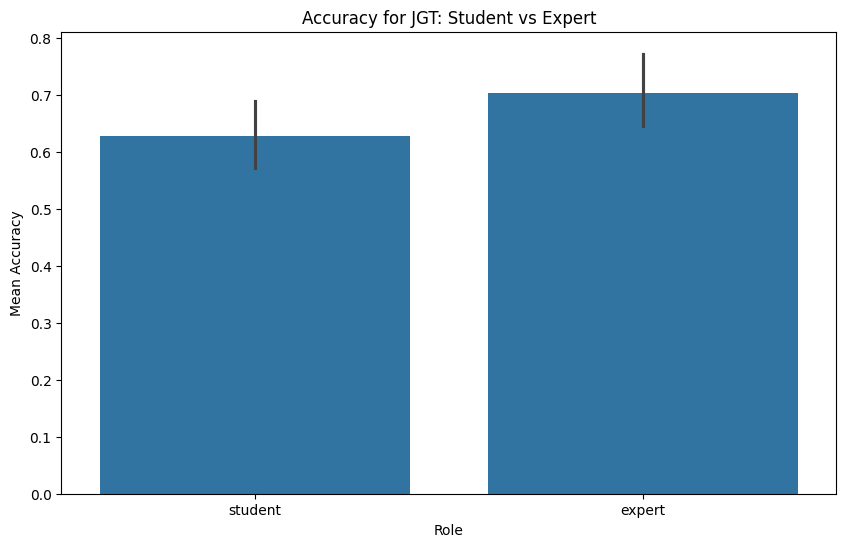

In [125]:
# Compare JGT vs ANS
jgt_ans_df = merged_df[merged_df['prompt_template'].str.contains('jgt|ans')]

plt.figure(figsize=(10, 6))
sns.barplot(x='prompt_template', y='accuracy_mean', data=jgt_ans_df)
plt.title('Accuracy: JGT vs ANS')
plt.xticks(rotation=45)
plt.ylabel('Mean Accuracy')
plt.xlabel('Prompt Template')
plt.show()

# Compare accuracy for JGT with different roles (student, expert)
jgt_df = merged_df[merged_df['prompt_template'].str.contains('jgt')]
plt.figure(figsize=(10, 6))
sns.barplot(x='role', y='accuracy_mean', data=jgt_df)
plt.title('Accuracy for JGT: Student vs Expert')
plt.ylabel('Mean Accuracy')
plt.xlabel('Role')
plt.show()


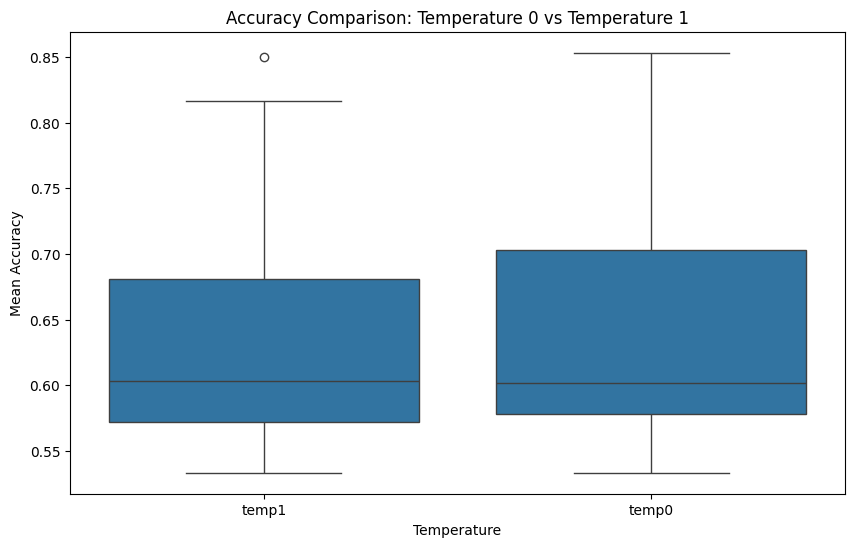

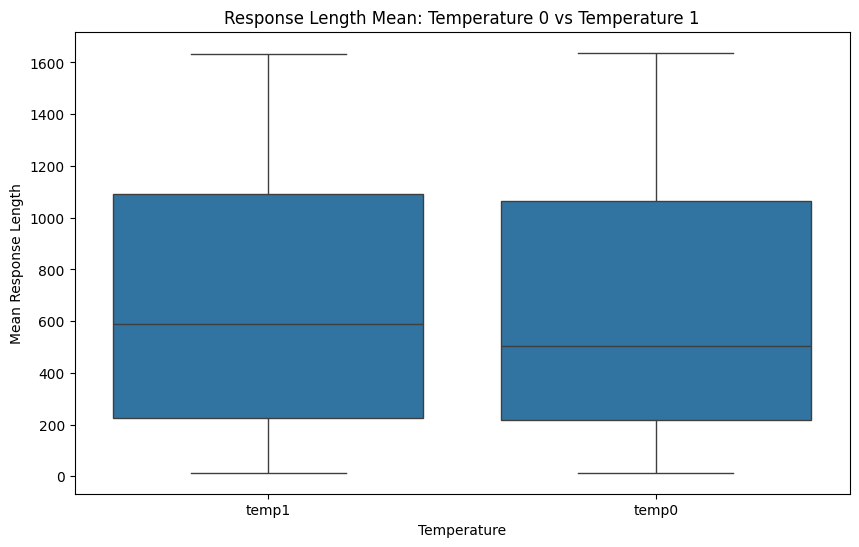

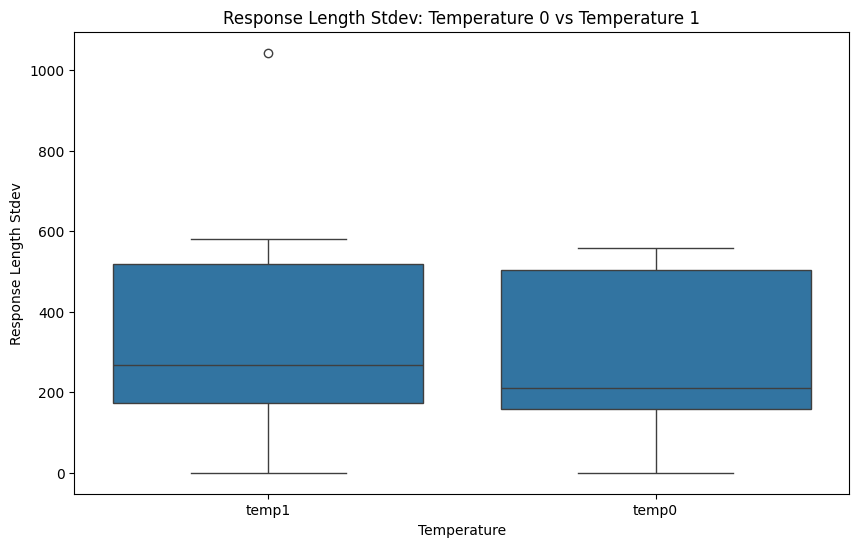

In [127]:
# Compare accuracy by temperature
plt.figure(figsize=(10, 6))
sns.boxplot(x='temperature', y='accuracy_mean', data=merged_df)
plt.title('Accuracy Comparison: Temperature 0 vs Temperature 1')
plt.ylabel('Mean Accuracy')
plt.xlabel('Temperature')
plt.show()

# Compare response length mean by temperature
plt.figure(figsize=(10, 6))
sns.boxplot(x='temperature', y='response_length_mean_0', data=merged_df)
plt.title('Response Length Mean: Temperature 0 vs Temperature 1')
plt.ylabel('Mean Response Length')
plt.xlabel('Temperature')
plt.show()

# Compare response length stdev by temperature
plt.figure(figsize=(10, 6))
sns.boxplot(x='temperature', y='response_length_stdev_0', data=merged_df)
plt.title('Response Length Stdev: Temperature 0 vs Temperature 1')
plt.ylabel('Response Length Stdev')
plt.xlabel('Temperature')
plt.show()


In [165]:
print("The following are multiple-choice questions (with answers). Begin your response with \"The answer is (X)\" where X is the correct letter choice.\n\nQuestion: Typical advertising regulatory bodies suggest, for example that adverts must not: encourage _________, cause unnecessary ________ or _____, and must not cause _______ offence.\n\nOptions: A: Safe practices, Fear, Jealousy, Trivial, B: Unsafe practices, Distress, Joy, Trivial, C: Safe practices, Wants, Jealousy, Trivial, D: Safe practices, Distress, Fear, Trivial, E: Unsafe practices, Wants, Jealousy, Serious, F: Safe practices, Distress, Jealousy, Serious, G: Safe practices, Wants, Fear, Serious, H: Unsafe practices, Wants, Fear, Trivial, I: Unsafe practices, Distress, Fear, Serious\n")

The following are multiple-choice questions (with answers). Begin your response with "The answer is (X)" where X is the correct letter choice.

Question: Typical advertising regulatory bodies suggest, for example that adverts must not: encourage _________, cause unnecessary ________ or _____, and must not cause _______ offence.

Options: A: Safe practices, Fear, Jealousy, Trivial, B: Unsafe practices, Distress, Joy, Trivial, C: Safe practices, Wants, Jealousy, Trivial, D: Safe practices, Distress, Fear, Trivial, E: Unsafe practices, Wants, Jealousy, Serious, F: Safe practices, Distress, Jealousy, Serious, G: Safe practices, Wants, Fear, Serious, H: Unsafe practices, Wants, Fear, Trivial, I: Unsafe practices, Distress, Fear, Serious

